In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
from PIL import Image

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [3]:
ARTIFACTS_FOLDER = "./artifacts"
level5data = LyftDataset(data_path='.', json_path='train_data', verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 11.1 seconds.
Reverse indexing ...
Done reverse indexing in 4.0 seconds.


In [4]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian",
           "other_vehicle", "animal", "emergency_vehicle"]

In [5]:
trainData = pd.read_csv('train.csv')
trainData.info()
trainData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22680 entries, 0 to 22679
Data columns (total 2 columns):
Id                  22680 non-null object
PredictionString    22680 non-null object
dtypes: object(2)
memory usage: 354.5+ KB


,Id,PredictionString
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...


In [6]:
idLst = list()
trainRow = 0

predictionDf = pd.DataFrame(trainData.PredictionString.str.split(expand = True))
predDf = pd.DataFrame(predictionDf.values.reshape(-1, 8), 
             columns=['center_x','center_y','center_z','width','length','height','yaw','class_name'])

for ind, row in trainData.iterrows():
    for i in range(130):
        idLst.append(trainData.iloc[trainRow,0])
    trainRow += 1

df = pd.concat([pd.DataFrame(idLst, columns=['id']), predDf],axis=1)
df.dropna(inplace= True)
df = df[['id','center_x', 'center_y', 'width', 'height', 'class_name']]
df.head()

,id,center_x,center_y,width,height,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527,698.1969292852777,2.064,2.053,car
1,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2691.997461646401,660.8016536569899,1.818,1.608,car
2,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2713.6075009338388,694.4034809694599,1.779,1.62,car
3,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2679.986916931015,706.9101495091695,1.798,1.722,car
4,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2659.352095715659,719.4174623706303,1.936,1.921,car


In [7]:
df.shape

(638179, 6)

In [8]:
sample = pd.DataFrame(level5data.sample_data)
sample = sample[['filename','sample_token','token']][sample.fileformat == 'jpeg'].drop_duplicates()
sample.head()

,filename,sample_token,token
2,images/host-a007_cam6_1234740264650905006.jpeg,254cea140f7d14fc86e73f789794fb73f81c05831d40f3...,454c65ee6c297d64b17852b4c56def9781a84dcb8558a8...
3,images/host-a007_cam3_1230936242299360006.jpeg,810503d8ca51e9692021ecb56e2b2f2098beaf396cd207...,779018e1f92debcf5c5c28e9577677c6595679780bdf9b...
4,images/host-a004_cam2_1233685223917652006.jpeg,119b8c4bbaf1493bebaaa7d823934a8a3f5a80fb095630...,d966960819eb0aca2883cd3c8d8c5e2540bda952a8cada...
5,images/host-a101_cam5_1242748828932442006.jpeg,32a71cf987e8922a85d052bfcc477e19c56733f453bc94...,c38472dca62728a33c15da9de3bc21aa57a063881aafaa...
6,images/host-a011_cam5_1233090640267719006.jpeg,d1b36f15c13de84d38a795dbbc2fe42a848f5f83968d42...,0cdaef801e20d2d917dd35719c224447c6eff899dfda55...


In [9]:
annot = pd.DataFrame(level5data.sample_annotation)
annot['center_x'] = annot.translation.str[0]
annot['center_y'] = annot.translation.str[1]
annot['center_z'] = annot.translation.str[2]
annot = annot[['sample_token','token','category_name','center_x','center_y','center_z']]
annot.head()

,sample_token,token,category_name,center_x,center_y,center_z
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,92bff46db1dbfc9679edc8091770c4256ac3c027e9f0a9...,car,2680.283036,698.196929,-18.047767
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,04c4c9883de582c5c4e7a45273a978a52b0432de18883f...,car,1208.642685,1585.181295,-23.562364
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,4226ce1636193ced735e21ff3c6dcc292415c72d0f84b4...,car,848.934679,2587.287056,-20.159957
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,f2446d4ca4b3e79e982cf0a4134af12e71e7b59df42f42...,car,1994.432028,1128.301643,-18.054752
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1f5bdec4a1dff45dbbb4db094445dd4051eb39c9b4a2a3...,car,1030.387716,1667.131317,-23.764820


In [10]:
sc = pd.DataFrame(level5data.scene)
sd = pd.DataFrame(level5data.sample_data)
sa = pd.DataFrame(level5data.sample)
e = pd.DataFrame(level5data.ego_pose)
a = pd.DataFrame(level5data.sample_annotation)

In [11]:
level5data.list_scenes()

host-a007-lidar0-1230485630199365106-12304856550990... [19-01-02 17:33:50]   25s, Palo Alto, #anns:1559
host-a007-lidar0-1230672860198383106-12306728850991... [19-01-04 21:34:20]   25s, Palo Alto, #anns:2969
host-a007-lidar0-1230936221299185986-12309362461986... [19-01-07 22:43:41]   25s, Palo Alto, #anns:683
host-a007-lidar0-1231093036199514746-12310930610996... [19-01-09 18:17:16]   25s, Palo Alto, #anns:3117
host-a009-lidar0-1231200854198312986-12312008790984... [19-01-11 00:14:14]   25s, Palo Alto, #anns:681
host-a005-lidar0-1231201437298603426-12312014621988... [19-01-11 00:23:57]   25s, Palo Alto, #anns:3064
host-a011-lidar0-1232401360198078026-12324013850983... [19-01-24 21:42:40]   25s, Palo Alto, #anns:3842
host-a011-lidar0-1232412236198491106-12324122610982... [19-01-25 00:43:56]   25s, Palo Alto, #anns:372
host-a007-lidar0-1232470052198454586-12324700770988... [19-01-25 16:47:32]   25s, Palo Alto, #anns:1614
host-a011-lidar0-1232485958298280666-12324859832000... [19-01-25 21

In [12]:
my_scene = level5data.scene[179]
my_scene

{'description': '',
 'token': '457ee355fa9041d8560b7d9dd9322156ce7ea74f4b2233e3581d53b1959a70f0',
 'first_sample_token': '316bcb65b76fb70b7d368e0622be04d417af640e8e2b26120d9ae071560ceb4d',
 'name': 'host-a004-lidar0-1232905117299287546-1232905142198246226',
 'log_token': '457ee355fa9041d8560b7d9dd9322156ce7ea74f4b2233e3581d53b1959a70f0',
 'last_sample_token': 'b397cb3a331fe5a2ed7648638f3300eb5036eb295ed1e6c84ebe4a2fea6b5b93',
 'nbr_samples': 126}

In [13]:
first_sample_token = my_scene['first_sample_token']

In [14]:
my_sample = level5data.get('sample', first_sample_token)
my_sample

{'next': 'def5693fd81c130eacc5fe75f2a8be0278d33154472b5b0100699194d7dc8af8',
 'prev': '',
 'token': '316bcb65b76fb70b7d368e0622be04d417af640e8e2b26120d9ae071560ceb4d',
 'scene_token': '457ee355fa9041d8560b7d9dd9322156ce7ea74f4b2233e3581d53b1959a70f0',
 'timestamp': 1548869917402062.5,
 'data': {'CAM_BACK_RIGHT': '757faf5a894ede73f442314056af24944164d7a5cee792ea9ac708bac9bce0d3',
  'CAM_FRONT_ZOOMED': 'ff40981fd118ee8ee9bdc5d14a4d6e25e2005c466592b25f624ad419fdc211f7',
  'CAM_BACK_LEFT': '75f17ed68c0b2c0a4a27ba3f0ae734f1e297c62fe1d0d28449a43bfb3f5a0c0c',
  'LIDAR_TOP': 'ad4d545e2828f47e9095d988508157a4583d7cc8b81b7091cd0227d46bcd7b84',
  'CAM_FRONT_RIGHT': '572a652de4abe2f8f90849a2eb7a4e9e90cabb87aec244f21dbcd100e1d109ee',
  'CAM_BACK': 'ce5fd30cb216d1f16ce09b475a1348c33f770919bb8c0063edbc444b42bed0e1',
  'CAM_FRONT': '2dc3896fc11810769531d68d1bdff40dadeb5bf135460c40bd4ab473fdd87b7b',
  'CAM_FRONT_LEFT': 'c0fed31b9d3361feae770147a4861caae33f869bef7a7d87f6eddeec02f80809'},
 'anns': ['d101

In [15]:
level5data.list_sample(my_sample['token'])

Sample: 316bcb65b76fb70b7d368e0622be04d417af640e8e2b26120d9ae071560ceb4d

sample_data_token: 757faf5a894ede73f442314056af24944164d7a5cee792ea9ac708bac9bce0d3, mod: camera, channel: CAM_BACK_RIGHT
sample_data_token: ff40981fd118ee8ee9bdc5d14a4d6e25e2005c466592b25f624ad419fdc211f7, mod: camera, channel: CAM_FRONT_ZOOMED
sample_data_token: 75f17ed68c0b2c0a4a27ba3f0ae734f1e297c62fe1d0d28449a43bfb3f5a0c0c, mod: camera, channel: CAM_BACK_LEFT
sample_data_token: ad4d545e2828f47e9095d988508157a4583d7cc8b81b7091cd0227d46bcd7b84, mod: lidar, channel: LIDAR_TOP
sample_data_token: 572a652de4abe2f8f90849a2eb7a4e9e90cabb87aec244f21dbcd100e1d109ee, mod: camera, channel: CAM_FRONT_RIGHT
sample_data_token: ce5fd30cb216d1f16ce09b475a1348c33f770919bb8c0063edbc444b42bed0e1, mod: camera, channel: CAM_BACK
sample_data_token: 2dc3896fc11810769531d68d1bdff40dadeb5bf135460c40bd4ab473fdd87b7b, mod: camera, channel: CAM_FRONT
sample_data_token: c0fed31b9d3361feae770147a4861caae33f869bef7a7d87f6eddeec02f80809, mo

In [16]:
my_sample['data']

{'CAM_BACK_RIGHT': '757faf5a894ede73f442314056af24944164d7a5cee792ea9ac708bac9bce0d3',
 'CAM_FRONT_ZOOMED': 'ff40981fd118ee8ee9bdc5d14a4d6e25e2005c466592b25f624ad419fdc211f7',
 'CAM_BACK_LEFT': '75f17ed68c0b2c0a4a27ba3f0ae734f1e297c62fe1d0d28449a43bfb3f5a0c0c',
 'LIDAR_TOP': 'ad4d545e2828f47e9095d988508157a4583d7cc8b81b7091cd0227d46bcd7b84',
 'CAM_FRONT_RIGHT': '572a652de4abe2f8f90849a2eb7a4e9e90cabb87aec244f21dbcd100e1d109ee',
 'CAM_BACK': 'ce5fd30cb216d1f16ce09b475a1348c33f770919bb8c0063edbc444b42bed0e1',
 'CAM_FRONT': '2dc3896fc11810769531d68d1bdff40dadeb5bf135460c40bd4ab473fdd87b7b',
 'CAM_FRONT_LEFT': 'c0fed31b9d3361feae770147a4861caae33f869bef7a7d87f6eddeec02f80809'}

In [17]:
sensor = 'CAM_FRONT'
#sampled = level5data.sample_data['filename' == 'images/host-a004_cam3_1232905117300897006.jpeg']
#sampled
#sample_data['filename' =='images/host-a004_cam3_1232905117300897006.jpeg']
cam_front_data = level5data.get('sample_data', my_sample['data'][sensor])
cam_front_data #ad87e1763749cc8562cca68e2046db128185c80c3e759919f5da448e5d9d9696

{'width': 1224,
 'height': 1024,
 'calibrated_sensor_token': '272b2a71e06f9cf99cfa0897a4dfaf41bd93dd101d2cb61ecb7934e911145bca',
 'token': '2dc3896fc11810769531d68d1bdff40dadeb5bf135460c40bd4ab473fdd87b7b',
 'sample_token': '316bcb65b76fb70b7d368e0622be04d417af640e8e2b26120d9ae071560ceb4d',
 'is_key_frame': True,
 'prev': '',
 'fileformat': 'jpeg',
 'ego_pose_token': '0104e73641a95b54ee0d21eef03a784ee01dd5166eb59dbbd427c32a038a3a55',
 'timestamp': 1548869917351064.0,
 'next': '3b2f3f8ee84264810286de00e5e947e3cef7c797f3ebf277f8f94711a9965e08',
 'filename': 'images/host-a004_cam0_1232905117351064006.jpeg',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

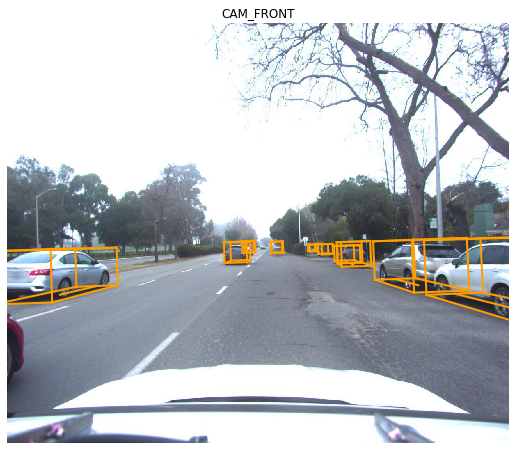

In [18]:
level5data.render_sample_data(cam_front_data['token'])

In [19]:
my_annotation_token = my_sample['anns'][18]
my_annotation_metadata =  level5data.get('sample_annotation', my_annotation_token)
my_annotation_metadata

{'token': '8c0ddec5a82575212770a8b2f75f5740c5476198e99bc8f2b5e9c0e5a5f6709d',
 'num_lidar_pts': -1,
 'size': [1.987, 4.548, 1.485],
 'sample_token': '316bcb65b76fb70b7d368e0622be04d417af640e8e2b26120d9ae071560ceb4d',
 'rotation': [-0.9629153268709643, 0, 0, 0.26980376809263457],
 'prev': '',
 'translation': [1680.410016297405, 1300.1837663237388, -19.939181510692247],
 'num_radar_pts': 0,
 'attribute_tokens': ['7fc1ca3d36808cd1858e9c01ad4e7630ff3ca9e720065034abd244122646acc8'],
 'next': '72bce0911c45735442d0de5519ca4926b0ce4d9178e2639a21f541ed6dec6814',
 'instance_token': '50553bc8bba530c2dc1fa28aba9fbc69e5a40c63c4e9506df77cc95d261630da',
 'visibility_token': '',
 'category_name': 'car'}

In [20]:
host = sample.filename.str.split('-').str[1].str.split('_').str[0].unique()
cam = sample.filename.str.split('-').str[1].str.split('_1').str[0].unique()
host, cam

(array(['a007', 'a004', 'a101', 'a011', 'a017', 'a008', 'a102', 'a012',
        'a005', 'a006', 'a009', 'a015'], dtype=object),
 array(['a007_cam6', 'a007_cam3', 'a004_cam2', 'a101_cam5', 'a011_cam5',
        'a017_cam0', 'a004_cam3', 'a101_cam6', 'a004_cam5', 'a011_cam0',
        'a007_cam0', 'a011_cam3', 'a008_cam1', 'a007_cam2', 'a011_cam2',
        'a102_cam6', 'a007_cam5', 'a004_cam0', 'a004_cam4', 'a011_cam6',
        'a012_cam4', 'a007_cam4', 'a005_cam3', 'a006_cam6', 'a008_cam6',
        'a101_cam4', 'a009_cam2', 'a017_cam6', 'a101_cam3', 'a017_cam2',
        'a004_cam1', 'a015_cam1', 'a017_cam3', 'a011_cam1', 'a101_cam1',
        'a011_cam4', 'a102_cam3', 'a006_cam3', 'a009_cam0', 'a015_cam2',
        'a005_cam5', 'a007_cam1', 'a004_cam6', 'a009_cam6', 'a101_cam0',
        'a015_cam3', 'a017_cam5', 'a008_cam0', 'a008_cam2', 'a009_cam5',
        'a009_cam3', 'a008_cam3', 'a015_cam5', 'a009_cam1', 'a102_cam2',
        'a102_cam4', 'a102_cam0', 'a102_cam5', 'a012_cam1', 'a102_cam

In [21]:
len(cam)

84